매우 적은 데이터를사용하여 이미지 분류 모델을 훈련하는 일은 흔한 경우 입니다. 여러분이 전문적인 컴퓨터 비전 작업을 한다면 실제로 이런 상황을 마주치게 될 가능성이 높습니다. 보통 '적은'샘플이란 수백 개에서 수만 개 사이를 의미합니다. 실용적인 예제로 4,000개의 강아지와 고양이사진(2,000개는 강아지, 2,000개는 고양이)으로 구성된 데이터셋에서 강아지와 고양이 이미지를 분류해 보겠습니다. 훈련을 위해 2,000개의 사진을 사용하고 검증과 테스트에 각각 1,000개의 사진을 사용합니다.

이 절에서 문제를 해결하기 위해 기본적인 전략 하나를 살펴볼 것입니다. 보유한 소규모 데이터셋을 사용하여 처음부터 새로운 모델을 훈련하는것입니다. 2,000개의 훈련 샘플에서 작은 컨브넷을 어떤 규제 방법도 사용하지 않고 훈련하여 기준이 되는 기본 성능을 만들겠습니다. 이 방법은 71%의 분류 정확도를 달성할 것입니다. 이 방법의 주요 이슈는 과대적합이 될 것입니다. 그다음 컴퓨터 ㅣ전에서 과대적합을 줄이기 위한 강력한 방법인 데이터 증식을 소개하겠습니다. 데이터 증식을 통해 네트워크의 성능을 82% 정확도로 향상시킬 것입니다.

다음 절에서 작은 데이터셋에 딥러닝을 정용하기 위한 핵심적인 기술 두 가지를 살펴보겠습니다, 사전 훈련된 네트워크로 특엇을 추출하는 것(90% 정확도를 얻게 됩니다)과 사전 훈련된 네트워크를 세밀하게 튜닝하는 것입니다(최종모델은 92%정확도를 얻을 것입니다). 이런 세 가지 전략은 작은 테이터셋에서 이미지 분류 문제를 수행할 떄 여러분의 도구 상자에 포함되어 있어야 합니다.

##작은 데이터셋 문제에서 딥러닝의 타당성

딥러닝은 데이터가 풍부할 때만 작동한다는 말을 이따금 듣습니다. 부분적으로는 맞습니다. 딥러닝의 근본적인 특징은 훈련 데이터에서 특성 공학의 수작업 없이 흥미로운 특성을 찾을 수 있는 것입니다. 이는 훈련 샘플이 많아야만 가능합니다. 입력 샘플이 이미지처럼 매우 고차원인 문제에서는 특히 그렇습니다.

하지만 많은 샘플이 의미하는 것은 상대적입니다. 우선 훈련하려는 네트워크의 크기가 깊이에 상대적입니다. 복잡한 문제를 푸는 컨브넷을 수십 개의 샘플만 사용해서 훈련하는 것은 불가능합니다. 하지만 모델이 작고 규제가 잘 되어 있으며 간단한 작업이라면 수백 개의 샘플로도 충분할 수 있습니다. 컨브넷은 지역적이고 평행이동으로 변하지 않는 특성을 학습하기 때문에 지각에 관한 문제에서 매우 효율적으로 데이터를 사용합니다. 매우 작은 이미지 데이터셋에서 어떤 종류의 특성 공학을 사용하지 않고 컨브넷을 처음부터 훈련해도 납득할 만한 결과를 만들 수 있습니다. 이 절에서 실젤 이런 결과를 보게 될 것입니다.

거기에 더하여 딥러닝 모델은 태생적으로 매우 다목적입니다. 말하자면 대규모 데이터셋에서 훈련시킨 이미지 분류 모델이나 스피치-투-텍스트(speech-to-text) 모델을 조금만 변경해서 완전히 다른 문제에서 재사용 할 수 있습니다. 특히 컴퓨터 비전에서는(보통 imageNet 데이터셋에서 훈련된)사전 훈련된 모델을이 내려받을 수 있도록 많이 공개되어 있어서 매우 적은 데이터에서 강력한 비전 모델을 만드는 데 사용할 수 있습니다. 바로 다음 절에서 우리가 해 볼 것입니다. 먼저 데이터를 구하느 것부터 시작해보죠

##데이터 내려받기

여기서 사용할 강아지 VS 고양이 데이터셋은 케라스에 포함되어 있지 않습니다. 컨브넷이 주류가 되기 전인 2013년 후반에 캐글에서 컴퓨터 비전 경연대회의 일환으로 이 데이터셋을 만들었습니다. 원본 데이터셋을 https://www.kaggle.com/c/dogs-vs-cats/data 에서 내려받을 수 있습니다.(캐글 계정이 없다면 하나 만들어야 하지만 과정을 만드는 과정은 간단합니다.)

그리고 편의상 캐글에서 받은 데이터를 구글 드라이브에 공유하겠습니다.

In [ ]:
import os, shutil
original_dataset_dir = '/content/drive/MyDrive/Classroom/케라스 창시자에게 배우는 딥러닝 연습 폴더/dogs-vs-cats.zip/train'
base_dir = '/content/drive/MyDrive/Classroom/케라스 창시자에게 배우는 딥러닝 연습 폴더/dogs-vs-cats.zip/cats_and_dogs_small'

In [ ]:
os.mkdir(base_dir)

훈련, 검증, 테스트 분할을 위한 디렉터리

In [ ]:
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir= os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

훈련용 고양이 사진 디렉터리

In [ ]:
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

훈련용 강아지 사진 디렉터리

In [ ]:
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

In [ ]:
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

In [ ]:
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

In [ ]:
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

In [ ]:
test_dogs_dir = os.path.join(test_dir,'dogs')
os.mkdir(test_dogs_dir)

처음 1,000개의 고양이 이미지를 train_cats_dir에 복사합니다.

In [ ]:
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

다음 500개의 고양이 이미지를 validation_cats_dir에 복사합니다

In [ ]:
fnames = ['cat.{}.jpg'.format(i) for i in range(1000,1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

다음 500개의 고양이 이미지를 test_cats_dir에 복사합니다.

In [ ]:
fnames = ['cat.{}.jpg'.format(i) for i in range(1500,2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
fnames = ['dog.{}.jpg'.format(i) for i in range(1000,1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
fnames = ['dog.{}.jpg'.format(i) for i in range(1500,2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

복사가 잘 되었는지 확인하기 위해 각 분한에 들어있는 사진의 개수를 카운트 해 보죠

In [ ]:
print('훈련용 고양이 이미지 전체 개수:', len(os.listdir(train_cats_dir)))

훈련용 고양이 이미지 전체 개수: 1000


In [ ]:
print('훈련용 강아지 이미지 전체 개수:', len(os.listdir(train_dogs_dir)))

훈련용 강아지 이미지 전체 개수: 1000


In [ ]:
print('검증용 고양이 이미지 전체 개수:', len(os.listdir(validation_cats_dir)))

검증용 고양이 이미지 전체 개수: 500


In [ ]:
print('검증용 강아지 이미지 전체 개수:', len(os.listdir(validation_dogs_dir)))

검증용 강아지 이미지 전체 개수: 500


In [ ]:
print('테스트용 고양이 이미지 전체 개수:', len(os.listdir(test_cats_dir)))

테스트용 고양이 이미지 전체 개수: 500


In [ ]:
print('테스트용 강아지 이미지 전체 개수:', len(os.listdir(test_dogs_dir)))

테스트용 강아지 이미지 전체 개수: 500


이제 2000개의 훈련 이미지, 1000개의 검증 이미지, 1000개의 테스트 이미지가 준비되었습니다. 분할된 각 데이터는 클래스마다 동일한 개수의 샘플을 포함합니다. 균형 잡힌 이진 분류 문제이므로 정확도를 사용하여 성공을 측정하겠습니다.

##네트워크 구성하기
이전 예제게서 MNIST를 위해 간단한 컨브넷을 만들었습니다. 이제 컨브넷에 친숙해졌을 것입니다. 여기서 사용할 구조도 일반적으로 동일합니다. Con22D(relu 활성화 함수 사용)와 MaxPooling2D층을 번갈아 쌓은 컨브넷을 만들겠습니다. 이전보다 이미지가 크고 복잡한 문제이기 때문에 네트워크를 좀 더 크게 만들겠습니다. Conv2D + MaxPooling2D단계를 하나 더 추가합니다. 이렇게 하면 네트워크의 용량을 늘리고 Flatten층의 크기가 너무 커지지 않도록 특성 맵의 크기를 줄일 수 있습니다. 150X150 크기(임의로 선택한 것입니다)의 입력으로 시작해서 Flatten 층 이전에 7X7크기의 특성 맵으로 줄어듭니다.

이진 분류 문제이므로 네트워크는 하나의 유닛(크기가 1인 Dense층)과 sigmoid 활성화 함수로 끝납니다. 이 유닛은 한 클래스에 대한 확률을 인코딩할 것입니다.

In [ ]:
from keras import models
from keras import layers

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

층들을 거치면서 특성 맵의 차원이 어떻게 변하는지 살펴보겠습니다.



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

컴파일 단계에서 이전과 같이 RMSprop 옵티마이저를 선택하겠습니다. 네트워크의 마지강이 하나의 시그모이드 유닛이기 때문에 이진 크로스엔트로피(binary crossentropy)를 손실로 사용합니다.

In [ ]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(learning_rate=1e-4),
             metrics=['acc'])

##데이터 전처리
데이터는 네트워크에 주입되기 전에 부동 소수 타입의 텐서로 적절하게 전처리되어 있어야 합니다. 지금은 데이터가 JPEG 파일로 되어 있으므로 네트워크에 주입하려면 대략 다음 과정을 따릅니다.

 1.사진 파일을 읽습니다.
 
 2.JPEG콘텐츠를 RGB 픽셀 값으로 디코딩 합니다.
 
 3.그다음 부동 소수 타입의 텐서로 변환
 
 4.픽셀값(0에서 255사이)의 스케일을 [0,1] 사이로 조정합니다(신경망은 작은 입력 값을 선호합니다).
좀 복잡하게 보일 수 있지만 다행히 케라스는 이런 단계를 자동으로 처리하는 유틸리티가 있습니다. 또 케라스에는 keras.preprocessing.image에 이미지 처리를 위한 헬퍼 도구들도 있습니다. 특히 ImageDataGenerator 클래스는 디스크에 있는 이미지 파일을 전처리된 배치 텐서로 자동으로 바꾸어 주는 파이썬 제너레이터를 만들어 줍니다. 이 클래스를 사용해 보겠습니다.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)  #모든 이미지를 1/255로 스케일을 조장합니다.
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_dir,  #타깃 디렉터리
                                                   target_size = (150, 150), #모든 이미지를 150*150 크기로 바꿉니다.
                                                   batch_size = 20,
                                                   class_mode = 'binary')   #binary_crossentropy 손실을 사용하기 때문에 이진 레이블이 필요

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                      target_size = (150, 150),
                                                      batch_size =20,
                                                      class_mode = 'binary')

NameError: ignored

##파이썬 제너레이터 이해하기
파이썬 제너레이터는 반복자 처럼 작동하는 객체로 for... in 연산자에 사용할 수 있습니다. 제너레이터는 yield 연산자를 사용하여 만듭니다. 다음은 정수를 반환하는 제너레이터의 예 입니다.

In [ ]:
def generator():
    i = 0
    while True:
        i += 1
        yield i

for item in generator():
    print(item)
    if item > 4:
        break

1
2
3
4
5


이 제너레이터의 출력 하나를 살펴보죠. 이 출력은 150 X 150 X RGB 이미지의 배치((20, 150, 150, 3)크기)와 이진 레이블의 배치((20,)크기)입니다. 각 배치에는 20개의 샘플(배치 크기)이 있습니다. 제너레이터는 이 배치를 무한정 만들어 냅니다. 타깃 폴더에 있는 이미지를 끝없이 반복합니다. 따라서 반복 루프 안 어디에선가 break 문을 사용해야 합니다.



In [ ]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (20, 150, 150, 3)
배치 레이블 크기: (20,)


제너레이터를 사용한 데이터에 모델을 훈련시켜 보겠습니다. fit_generator 메서드는 fit 메서드와 동일하되 데이터 제너레이터를 사용할 수 있습니다. 이 메서드는 첫 번째 매개변수로 입력과 타깃의 배치를 끝없이 반환하는 파이썬 제너레이터를 기대하비다. 데이터가 끝없이 생성되기 때문에 케라스 모델에 하나의 에포크를 정의하기 위해 제너레이터로부터 얼마나 많은 샘플을 뽑을것인지 알려주어야 합니다. steps_per_epoch 매개변수에서 이를 설정합니다. 제너레이터로부터 steps_per_epoch개의 배치만큼 뽑은 후, 즉 steps_per_epoch 횟수만큼 경사 하강법 단계를 실행한 수에 훈련 프로세스는 다음 에포크로 넘어갑니다. 여기서는 20개의 샘플이 하나의 배치이므로 2000개의 샘플을 모두 처리할 때까지 100개의 배치를 뽑을 것입니다.

fit_generator를 사용할 떄 fit 메서드와 마찬가지로 validation_data 매개변수를 전달할 수 있습니다. 이 매개변수에는 데이터 제너레이터도 가능하지만 넘파이 배열의 튜플도 가능합니다. validation_data로 제너레이터를 전달하면 검증 데이터의 배치를 끝없이 반환합니다. 따라서 검증 데이터 제너레이터에서 얼마나 많은 배치를 추출하여 평가할지 validation_steps 매개변수에 지정해야 합니다.



In [ ]:
#배치 제너레이터를 사용하여 모델 훈련하기
history = model.fit_generator(train_generator,
                             steps_per_epoch = 100,
                             epochs = 30,
                             validation_data = validation_generator,
                             validation_steps = 50)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 [==============================] - 124s 1s/step - loss: 0.6934 - acc: 0.5100 - val_loss: 0.6741 - val_acc: 0.5720
Epoch 2/30
100/100 [==============================] - 106s 1s/step - loss: 0.6677 - acc: 0.6041 - val_loss: 0.6668 - val_acc: 0.5730
Epoch 3/30
100/100 [==============================] - 105s 1s/step - loss: 0.6328 - acc: 0.6319 - val_loss: 0.6178 - val_acc: 0.6530
Epoch 4/30
100/100 [==============================] - 104s 1s/step - loss: 0.5818 - acc: 0.6794 - val_loss: 0.6107 - val_acc: 0.6620
Epoch 5/30
100/100 [==============================] - 104s 1s/step - loss: 0.5478 - acc: 0.7189 - val_loss: 0.5791 - val_acc: 0.6900
Epoch 6/30
100/100 [==============================] - 104s 1s/step - loss: 0.4971 - acc: 0.7417 - val_loss: 0.5663 - val_acc: 0.7050
Epoch 7/30
100/100 [==============================] - 104s 1s/step - loss: 0.4644 - acc: 0.7722 - val_loss: 0.5598 - val_acc: 0.7060
Epoch 8/30
100/100 [==============================] - 104s 1s/step - 

훈련이 끝나면 항상 모델을 저장하는 것이 좋은 습관입니다,

In [ ]:
model.save('cats_and_dogs_small_1.h5')

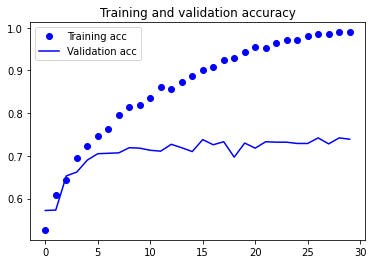

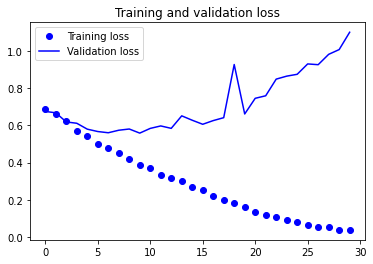

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

이 그래프는 과대적합의 특성을 보여줍니다. 훈련 정확도가 시간이 지남에 따라 선형적으로 증가해서 거의 100%에 도달합니다. 반면 검증 정확도는 70-72%에서 멈추었습니다. 검증 손실은 다섯 번의 에포크만에 최솟값에 다다른 이후에 더 이상 진전되지 않았습니다. 반면 훈련 손실은 거의 0에 도달할 때까지 선형적으로 계속 감소합니다.

비교적 훈련 샘플의 수(2,000개)가 적기 때문에 과대적합이 가장 중요한 문제입니다. 드롭아웃이나 가중치 감소(L2 규제)와 같은 과대적합을 감소시킬 수 있는 여러 가지 기법들을 배웠습니다. 여기에서는 컴퓨터 비전에 특화되어 있어서 딥러닝으로 이미지를 다룰 때 매우 일반적으로 사용되는 새로운 방법인 데이터 증식을 시도해 보겠습니다.

##데이터 증식 사용하기
과대적합은 학습할 샘플이 너무 적어 새로운 데이터에 일반화할 수 있는 모델을 훈련시킬 수 없기 때문에 발생합니다. 무한히 많은 데이터가 주어지면 데이터 분포의 모든 가능한 측면을 모델이 학습할 수 있을 것입니다. 데이터 증식은 기존의 훈련 샘플로부터 더 많은 훈련 데이터를 생성하는 방법입니다. 이 방법은 그럴듯한 이미지를 생성하도록 여러 가지 랜덤한 변환을 적용하여 샘플을 늘립니다. 훈련 시에 모델이 정확히 같은 데이터를 두 번 만나지 않도록 하는 것이 목표입니다. 모델이 데이터의 여러 측면을 학습하면 일반화에 도움이 될 것입니다.

케라스에서는 ImageDataGenerator가 읽은 이미지에 여러 종류의 랜덤 변환을 적용하도록 설정할 수 있습니다. 예제를 먼저 만들어 보죠:

In [ ]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

추가적인 매개변수가 몇 개 더 있습니다(케라스 문서를 참고하세요). 이 코드를 간단히 살펴보죠. rotation_range는 랜덤하게 사진을 회전시킬 각도 범위입니다(0 ~180 사이). width_shift_range와 height_shift_range는 사진을 수펴와 수직으로 랜덤하게 평행이동 시킬벙위입니다(전체 너비와 높이에 대한 비율). shear_range는 랜덤하게 전단 변환(shearing transformation)을 적용할 각도 범위입니다. zoom_range는 랜덤하게 사진을 확대할 범위입니다. horizontl_flip은 랜덤하게 이미지를 수평으로 뒤집습니다. 수평 대칭을 가정할 수 있을 때 사용합니다(에를들면 풍경/인물 사진). fill_mode는 회전이나 가로/세로 이동으로 인해 새롭게 생성해야 할 칙셀을 채울 전략입니다. 증식된 이미지 샘플을 살펴보죠

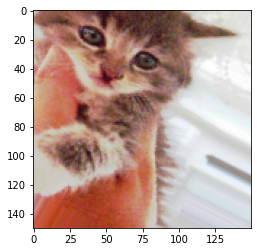

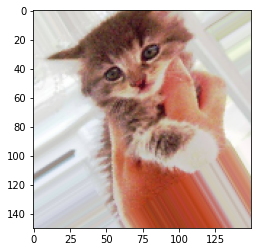

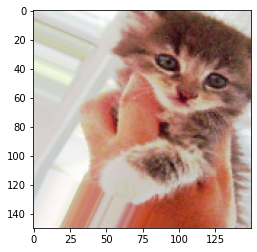

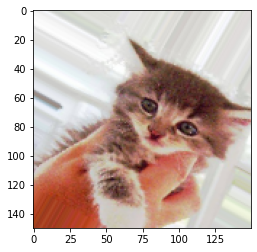

In [ ]:
from keras.preprocessing import image          #이미지 전처리 유틸리티 모듈

fnames =sorted([os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)])

img_path = fnames[3]    #증식할 이미지를 선택합니다.

img = image.load_img(img_path, target_size = (150,150))     # 이미지를 읽고 크기를 변경합니다.

x = image.img_to_array(img)    #(150,150,3) 크기의 넘파이 배열로 변환합니다.
x = x.reshape((1,) + x.shape)  #(1, 150,150,3) 크기로 변환합니다.

i = 0
for batch in datagen.flow(x, batch_size =1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

In [ ]:
#드롭아웃을 포함한 새로운 컨브넷 정의하기

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

데이터 증식과 드롭아웃을 사용하여 이 네트워크를 훈련시켜 봅시다.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=32,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블을 만들어야 합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 112s 1s/step - loss: 0.6880 - acc: 0.5375 - val_loss: 0.6815 - val_acc: 0.5660


만약 이게 안되시면 주피터 노트북으로 다운그레이드 하시면 됩니다.

만약에 되시면 저에게 어떻게 알려주시기 바랍니다.

5.3에서 오만짓을 다해도 저는 안돼서 그러는 겁니다.
주피터 노트북 다운그레이드도 코랩에서 이상한 짓을 해도 안됏습니다....
제발... 알려주시면 감사하겠습니다... 이거 5.4 절에서 'cats_and dogs_small_2.h5'에서 필요합니다... 제발... 성공 하셨다면 알려 주십쇼.... 

In [ ]:
model.save('cats_and_dogs_small_2.h5')

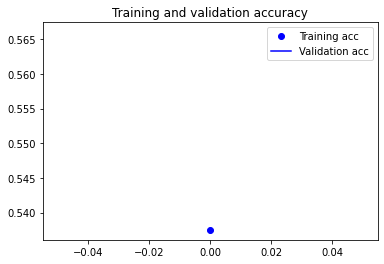

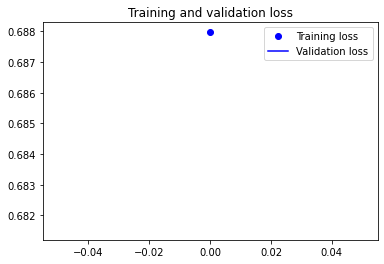

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

그림 5-12와 5-13을 참고하세요. 데이터 증식과 드롭아웃 덕택에 더이상 과대적합되지 않습니다. 훈련 곡선이 검증 곡선에 가깝게 따라가고 있습니다. 검증 데이터에서 82% 정확도를 달성하였습니다. 규제하지 않은 모델과 비교했을 때 15% 정도 향상되었습니다.

다른 규제 기법을 더 사용하고 네트워크의 파라미터를 튜닝하면(합성곱 층의 필터 수나 네트워크의 층의 수 등) 86%나 87% 정도까지 더 높은 정확도를 얻을 수도 있습니다. 하지만 데이터가 적기 때문에 컨브넷을 처음부터 훈련해서 더 높은 정확도를 달성하기는 어렵습니다. 이런 상황에서 정확도를 높이기 위한 다음 단계는 사전 훈련된 모델을 사용하는 것입니다. 다음 두 절에서 이에 대해 집중적으로 살펴보겠습니다.